In [1]:
import tensorflow as tf
import numpy as np


import pandas as pd
import openpyxl # Needed for reading excel
import pathlib


In [2]:
# SAMPLES = 32
# TIME = 6
# FEATURES = 40
# generator = tf.random.Generator.from_seed(1)
# data = generator.normal(shape=[40, 3])
# X = generator.normal(shape=[SAMPLES, TIME, FEATURES])
# y = generator.normal(shape=[SAMPLES, 2])

In [3]:
from decomposition import Filter
class IterativeFilterCallback(tf.keras.callbacks.Callback):
    def __init__(self, windower, model_class, iterations=2, iteration=0, threshold=0.2):
        # self.train_dataset = train_dataset
        # self.iteration = iteration
        # self.iterations = iterations
        self.model_class = model_class
        self.threshold = threshold
        self.windower = windower

        if isinstance(threshold, int):
            self.k = threshold
        

    def on_train_end(self, logs={}):
        # if self.iteration >= self.iterations:
        #     return
        model = self.model

        attention_weights = []
        for x, _ in self.windower.train:
            attention_weights.append(model.get_attention_weights(x))
        
        # print(attention_weights)
        attention_weights = tf.concat(attention_weights, axis=0)
        averaged_attention_weights = tf.math.reduce_mean(tf.math.reduce_mean(attention_weights, axis=0), axis=0)
        # print(averaged_attention_weights)
        
        ######## THIS IS TEMPORARY ########
        self.threshold = tf.reduce_mean(averaged_attention_weights)
        ######## THIS IS TEMPORARY ########

        try:
            self.indices = tf.math.top_k(averaged_attention_weights, self.k, sorted=False).indices
            # print(self.indices)

        except AttributeError:
            self.mask = averaged_attention_weights >= self.threshold
            self.indices = tf.where(self.mask)

        columns = self.windower.train_df.columns[tf.reshape(self.indices, (-1,))]
        # print(columns)
        columns = list(columns) + self.windower.label_columns
        # columns = list(set(columns))
        filter = Filter(columns)
        
        filtered_windower = self.windower.copy()
        filtered_windower.preprocess(filter)
        self.filtered_windower = filtered_windower


In [4]:
#model.summary()


In [5]:

cwd = pathlib.Path.cwd()

code_directory = cwd.parents[1]

bas_directory = code_directory / "notebooks" / "Bas"
data_file = bas_directory / "cadeautjevoorGonemenLiza.xlsx"
data_file


df = pd.read_excel(data_file, header=[0, 1], index_col=0)
df.head(5)

AVG_TAVG                                      \
PARTNER_Labels           Brazil      France     Germany     Hungary   
TIME_PERIOD                                                           
2005-01-01 00:00:00  269.701032   50.081198   28.651592   -1.306452   
2005-02-01 00:00:00  266.743474   30.689158   -1.962406  -25.371429   
2005-03-01 00:00:00  266.528149   76.202630   45.730051   38.383871   
2005-04-01 00:00:00  253.719444  108.081105  101.859649  112.460000   
2005-05-01 00:00:00  247.859946  147.068032  134.667233  162.993548   

                                Corn Price Futures                          \
PARTNER_Labels          Ukraine             Brazil  France Germany Hungary   
TIME_PERIOD                                                                  
2005-01-01 00:00:00    0.869290                NaN     NaN     NaN     NaN   
2005-02-01 00:00:00  -38.376438             222.75  222.75  222.75  222.75   
2005-03-01 00:00:00   -3.794989             221.00  221.00  221.00  221.00   
2005-04-01 00:00:00   90.622214             213.50  213.50  213.50  213.50   
2005-05-01 00:00:00  161.493475             230.75  230.75  230.75  230.75   

                             ... renewable_energy_consumption_perc_of_total  \
PARTNER_Labels      Ukraine  ...                                     Brazil   
TIME_PERIOD                  ...                                              
2005-01-01 00:00:00     NaN  ...                                     46.130   
2005-02-01 00:00:00  222.75  ...                                     46.175   
2005-03-01 00:00:00  221.00  ...                                     46.220   
2005-04-01 00:00:00  213.50  ...                                     46.265   
2005-05-01 00:00:00  230.75  ...                                     46.310   

                                                        unemployment_total  \
PARTNER_Labels         France   Germany Hungary Ukraine             Brazil   
TIME_PERIOD                                                                  
2005-01-01 00:00:00  8.660000  7.280000  7.2900    1.27          10.550000   
2005-02-01 00:00:00  8.648333  7.389167  7.3375    1.31          10.478333   
2005-03-01 00:00:00  8.636667  7.498333  7.3850    1.35          10.406667   
2005-04-01 00:00:00  8.625000  7.607500  7.4325    1.39          10.335000   
2005-05-01 00:00:00  8.613333  7.716667  7.4800    1.43          10.263333   

                                                            
PARTNER_Labels         France    Germany Hungary   Ukraine  
TIME_PERIOD                                                 
2005-01-01 00:00:00  8.880000  11.170000   7.190  7.180000  
2005-02-01 00:00:00  8.875833  11.093333   7.215  7.149167  
2005-03-01 00:00:00  8.871667  11.016667   7.240  7.118333  
2005-04-01 00:00:00  8.867500  10.940000   7.265  7.087500  
2005-05-01 00:00:00  8.863333  10.863333   7.290  7.056667  

[5 rows x 75 columns]

In [6]:
label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()
df[label_columns] = np.log(df[label_columns])
df['price'].describe()

PARTNER_Labels,Brazil,France,Germany,Hungary,Ukraine
count,215.000000,215.000000,215.000000,215.000000,215.000000
mean,-1.442629,-1.647953,-1.620205,-1.622799,-1.602728
std,0.658525,0.317701,0.348058,0.554560,0.250238
min,-2.195615,-2.334697,-2.283213,-2.517279,-2.268743
25%,-1.826693,-1.854805,-1.853132,-1.979929,-1.751825
50%,-1.686989,-1.648511,-1.585693,-1.727030,-1.624369
75%,-1.391180,-1.482817,-1.472672,-1.482017,-1.483222
max,1.594099,-0.375176,0.867604,0.803969,-0.237961


In [7]:
from decomposition import STLDecomposer

label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()


stl_preprocessor = STLDecomposer(labels=label_columns, period=12)

# data = dc(df)
# data.head(5)

In [8]:
from windower import WindowGenerator

width = 24
label_width = 10
shift = 4

w = WindowGenerator(input_width=width, label_width=label_width, shift=shift, data=df, 
                    split=[0, 0.6, 0.85, 1], remove_labels=True)
w.preprocess(stl_preprocessor)
w

Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [18 19 20 21 22 23 24 25 26 27]
Label column name(s): None

In [9]:
w.train

<MapDataset element_spec=(TensorSpec(shape=(None, 24, 90), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10, 90), dtype=tf.float32, name=None))>

In [10]:
df = w.train_df
label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()
# label_columns = [('price', 'France')]
w.set_label_columns(label_columns)

In [46]:
# print(len(w.train_df.columns))
# w.train_df.columns

In [12]:
for example_inputs, example_labels in w.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 85)
Labels shape (batch, time, features): (32, 10, 5)


In [13]:
# for example_inputs, example_labels in w.train.take(1):
#     print(f'Inputs (batch, time, features): {example_inputs[1]}')
#     print(f'Labels (batch, time, features): {example_labels[1]}')

In [14]:
w.label_columns

[('price', 'Brazil'),
 ('price', 'France'),
 ('price', 'Germany'),
 ('price', 'Hungary'),
 ('price', 'Ukraine')]

In [19]:
h = 8  # Number of self-attention heads
d_k = 32  # Dimensionality of the linearly projected queries and keys
batch_size = 64  # Batch size from the training process


In [78]:
from model import EncoderDecoder, Feedback, SingleShot
len(label_columns)
m = FeedBack(out_steps=label_width, number_of_features=5, units=128, blocks=5, heads=8)
# m = EncoderDecoder(out_steps=label_width, number_of_features=5, units=128, blocks=5, heads=8)
# m = Model(num_feature_prediction=5, out_steps=label_width)
# m = SingleShot(out_steps=label_width, number_of_features=5, units=128, blocks=5, heads=8)
m.compile(
    loss='mse', 
    metrics=['mae', 'mse', 'mape'],
    run_eagerly=False,
    )

filter_callback = IterativeFilterCallback(w, model_class=Model, iterations=1, threshold=85)
m.fit(w.train, batch_size=32, epochs=5, validation_data=w.val)#, callbacks=[filter_callback])

Epoch 1/5
4/4 [==============================] - 17s 814ms/step - loss: 2.2519 - mae: 1.4407 - mse: 2.2519 - mape: 86.8920 - val_loss: 0.3576 - val_mae: 0.4229 - val_mse: 0.3576 - val_mape: 60.5029
Epoch 2/5
4/4 [==============================] - 0s 80ms/step - loss: 1.1499 - mae: 0.9179 - mse: 1.1499 - mape: 58.7104 - val_loss: 0.3099 - val_mae: 0.4607 - val_mse: 0.3099 - val_mape: 51.3327
Epoch 3/5
4/4 [==============================] - 0s 83ms/step - loss: 0.7402 - mae: 0.6108 - mse: 0.7402 - mape: 39.4864 - val_loss: 0.2642 - val_mae: 0.3978 - val_mse: 0.2642 - val_mape: 49.3308
Epoch 4/5
4/4 [==============================] - 0s 83ms/step - loss: 0.7047 - mae: 0.5954 - mse: 0.7047 - mape: 38.3287 - val_loss: 0.3443 - val_mae: 0.5237 - val_mse: 0.3443 - val_mape: 51.0170
Epoch 5/5
4/4 [==============================] - 0s 84ms/step - loss: 0.7544 - mae: 0.6132 - mse: 0.7544 - mape: 39.6270 - val_loss: 0.3300 - val_mae: 0.4831 - val_mse: 0.3300 - val_mape: 50.3689


In [66]:
for example_inputs, example_labels in filter_callback.filtered_windower.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

AttributeError: 'IterativeFilterCallback' object has no attribute 'filtered_windower'

In [ ]:
print(filter_callback.filtered_windower.train_df.columns)
filter_callback.filtered_windower.train_df.sort_index(axis=1).head(4)

MultiIndex([(  'energy_use_kg_of_oil_equivalent_per_capita',  'France'),
            ('fossil_fuel_energy_consumption_perc_of_total', 'Hungary'),
            (                                 'price_trend',  'Brazil'),
            (                              'price_seasonal',  'Brazil'),
            (                              'price_residual',  'Brazil'),
            (                                 'price_trend',  'France'),
            (                              'price_seasonal',  'France'),
            (                              'price_residual',  'France'),
            (                                 'price_trend', 'Germany'),
            (                              'price_seasonal', 'Germany'),
            (                              'price_residual', 'Germany'),
            (                                 'price_trend', 'Hungary'),
            (                              'price_seasonal', 'Hungary'),
            (                              'price_r

AVG_TAVG                                      \
                         Brazil      France     Germany     Hungary   
TIME_PERIOD                                                           
2005-01-01 00:00:00  269.701032   50.081198   28.651592   -1.306452   
2005-02-01 00:00:00  266.743474   30.689158   -1.962406  -25.371429   
2005-03-01 00:00:00  266.528149   76.202630   45.730051   38.383871   
2005-04-01 00:00:00  253.719444  108.081105  101.859649  112.460000   

                               Corn Price Futures                          \
                       Ukraine             Brazil  France Germany Hungary   
TIME_PERIOD                                                                 
2005-01-01 00:00:00   0.869290               0.00    0.00    0.00    0.00   
2005-02-01 00:00:00 -38.376438             222.75  222.75  222.75  222.75   
2005-03-01 00:00:00  -3.794989             221.00  221.00  221.00  221.00   
2005-04-01 00:00:00  90.622214             213.50  213.50  213.50  213.50   

                             ... renewable_energy_consumption_perc_of_total  \
                    Ukraine  ...                                     Brazil   
TIME_PERIOD                  ...                                              
2005-01-01 00:00:00    0.00  ...                                     46.130   
2005-02-01 00:00:00  222.75  ...                                     46.175   
2005-03-01 00:00:00  221.00  ...                                     46.220   
2005-04-01 00:00:00  213.50  ...                                     46.265   

                                                        unemployment_total  \
                       France   Germany Hungary Ukraine             Brazil   
TIME_PERIOD                                                                  
2005-01-01 00:00:00  8.660000  7.280000  7.2900    1.27          10.550000   
2005-02-01 00:00:00  8.648333  7.389167  7.3375    1.31          10.478333   
2005-03-01 00:00:00  8.636667  7.498333  7.3850    1.35          10.406667   
2005-04-01 00:00:00  8.625000  7.607500  7.4325    1.39          10.335000   

                                                            
                       France    Germany Hungary   Ukraine  
TIME_PERIOD                                                 
2005-01-01 00:00:00  8.880000  11.170000   7.190  7.180000  
2005-02-01 00:00:00  8.875833  11.093333   7.215  7.149167  
2005-03-01 00:00:00  8.871667  11.016667   7.240  7.118333  
2005-04-01 00:00:00  8.867500  10.940000   7.265  7.087500  

[4 rows x 90 columns]

In [20]:
filter_callback.threshold

<tf.Tensor: shape=(), dtype=float32, numpy=0.011764705>

In [21]:
w.label_columns

[('price', 'Brazil'),
 ('price', 'France'),
 ('price', 'Germany'),
 ('price', 'Hungary'),
 ('price', 'Ukraine')]

In [22]:
w = filter_callback.filtered_windower
w.train

<MapDataset element_spec=(TensorSpec(shape=(None, 24, 85), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10, 5), dtype=tf.float32, name=None))>

In [34]:
w = filter_callback.filtered_windower
# w.column_indices
# m = Model(len(w.column_indices))
m = FeedBack(pred_features=5, units=32, out_steps=label_width)
m.compile(
    loss='mse', 
    metrics=['mae', 'mse', 'mape'],
    run_eagerly=False,
    )

filter_callback1 = IterativeFilterCallback(w, model_class=Model, iterations=1, threshold=2)
m.fit(w.train, batch_size=32, epochs=100, validation_data=w.val, callbacks=[filter_callback1])

AttributeError: 'IterativeFilterCallback' object has no attribute 'filtered_windower'

In [ ]:
filter_callback1.filtered_windower.column_indices


{('OIL_PRICE $/bbl', 'France'): 0,
 ('gdp_current_us', 'France'): 1,
 ('price', 'Brazil'): 2,
 ('price', 'France'): 3,
 ('price', 'Germany'): 4,
 ('price', 'Hungary'): 5,
 ('price', 'Ukraine'): 6}

In [23]:
# Set NumPy print options to avoid scientific notation
np.set_printoptions(precision=4, suppress=True)

for example_inputs, example_labels in w.test.take(5):
    pred = tf.squeeze(m.predict(example_inputs)[:,:])
    unnormed_pred = (tf.squeeze(pred * w.train_std[label_columns].values)+w.train_mean[label_columns].values)
    # print(f'predictions: {pred}')
    lab = tf.squeeze(example_labels[:, :])
    unnormed_lab = ((lab * w.train_std[label_columns].values)+w.train_mean[label_columns].values).numpy()
    # print(f'labels: {lab.numpy()}')
    print(np.exp(tf.transpose(tf.stack([pred, lab]))))
    # attention_weights = m.get_attention_weights(example_inputs)
    # print(tf.squeeze(attention_weights))
    # print(f'normed labels: {example_labels[:,:,:].numpy()}')

m.evaluate(w.test)

1/1 [==============================] - 1s 907ms/step
[[[[5.7750e-01 4.3649e-01]
   [7.4075e-01 1.8335e+00]
   [2.8971e-05 2.5059e-01]
   [8.0607e-03 2.6851e-01]
   [9.5238e-02 4.9465e-01]
   [1.9162e-01 4.7087e-01]]

  [[2.3865e-01 2.6851e-01]
   [3.3583e-01 2.5059e-01]
   [4.2059e-10 4.7087e-01]
   [2.8949e-04 4.9465e-01]
   [6.3412e-02 9.3835e-01]
   [4.3820e+00 4.3649e-01]]

  [[9.0675e-02 4.9465e-01]
   [1.5804e-01 4.7087e-01]
   [4.2409e-15 4.3649e-01]
   [6.6882e-06 9.3835e-01]
   [2.9801e-02 2.8310e-01]
   [1.3476e+00 2.6851e-01]]

  [[3.5270e-02 9.3835e-01]
   [1.0033e-04 4.3649e-01]
   [3.1290e-16 2.6851e-01]
   [2.3259e-07 2.8310e-01]
   [1.5038e-02 3.5173e-01]
   [3.2614e-03 4.9465e-01]]

  [[1.4069e-02 2.8310e-01]
   [9.8116e-09 2.6851e-01]
   [2.5033e-16 4.9465e-01]
   [1.7106e-08 3.5173e-01]
   [7.7772e-03 1.7899e-01]
   [9.7160e-06 9.3835e-01]]

  [[6.0213e-03 3.5173e-01]
   [5.3727e-11 4.9465e-01]
   [8.8197e-17 9.3835e-01]
   [1.3655e-09 1.7899e-01]
   [4.1799e-03 2.90

[252.5068817138672, 10.73490047454834, 252.5068817138672, 843762816.0]

In [24]:
label_columns[1]
w.column_indices

{('fossil_fuel_energy_consumption_perc_of_total', 'Hungary'): 0,
 ('price_trend', 'Brazil'): 1,
 ('price_seasonal', 'Brazil'): 2,
 ('price_residual', 'Brazil'): 3,
 ('price_trend', 'France'): 4,
 ('price_seasonal', 'France'): 5,
 ('price_residual', 'France'): 6,
 ('price_trend', 'Germany'): 7,
 ('price_seasonal', 'Germany'): 8,
 ('price_residual', 'Germany'): 9,
 ('price_trend', 'Hungary'): 10,
 ('price_seasonal', 'Hungary'): 11,
 ('price_residual', 'Hungary'): 12,
 ('price_trend', 'Ukraine'): 13,
 ('price_seasonal', 'Ukraine'): 14,
 ('price_residual', 'Ukraine'): 15,
 ('AVG_TAVG', 'Brazil'): 16,
 ('AVG_TAVG', 'France'): 17,
 ('AVG_TAVG', 'Germany'): 18,
 ('AVG_TAVG', 'Hungary'): 19,
 ('AVG_TAVG', 'Ukraine'): 20,
 ('Corn Price Futures', 'Brazil'): 21,
 ('Corn Price Futures', 'France'): 22,
 ('Corn Price Futures', 'Germany'): 23,
 ('Corn Price Futures', 'Hungary'): 24,
 ('Corn Price Futures', 'Ukraine'): 25,
 ('MAX_TMAX', 'Brazil'): 26,
 ('MAX_TMAX', 'France'): 27,
 ('MAX_TMAX', 'German

tf.Tensor(
[[0.537037   0.43055552 0.68055546 0.18518516 0.68518513 0.30555552
  0.31018516 0.5648148  0.5694444  0.5648148  0.49074072 0.48148143
  0.43981478 0.67129624 0.68518513 0.31481478 0.68981475 0.69444436
  0.5648148  0.68518513 0.56018513 0.43981478 0.5648148  0.47685182
  0.81944436 0.5648148  0.81481475 0.31481478 0.45833328 0.73148143
  0.43518516 0.5555555  0.69444436 0.5648148  0.93981475 0.48611107
  0.43981478 0.56018513 0.43518516 0.18981479 0.52777773 0.47222218
  0.31481478 0.68055546 0.81481475 0.5509259  0.31481478 0.68518513
  0.31481478 0.68055546 0.43055552 0.5555555  0.43981478 0.43055552
  0.51388884 0.30555552 0.68981475 0.43518516 0.68055546 0.43518516
  0.44444442 0.5694444  0.81481475 0.5648148  0.31018516 0.69444436
  0.43518516 0.5092592  0.5555555  0.40740737 0.56018513 0.43055552
  0.43518516 0.68518513 0.5648148  0.56018513 0.67592585 0.31018516
  0.68518513 0.68981475 0.43981478 0.62499994 0.18518516 0.43981478
  0.68981475]], shape=(1, 85), dtype=

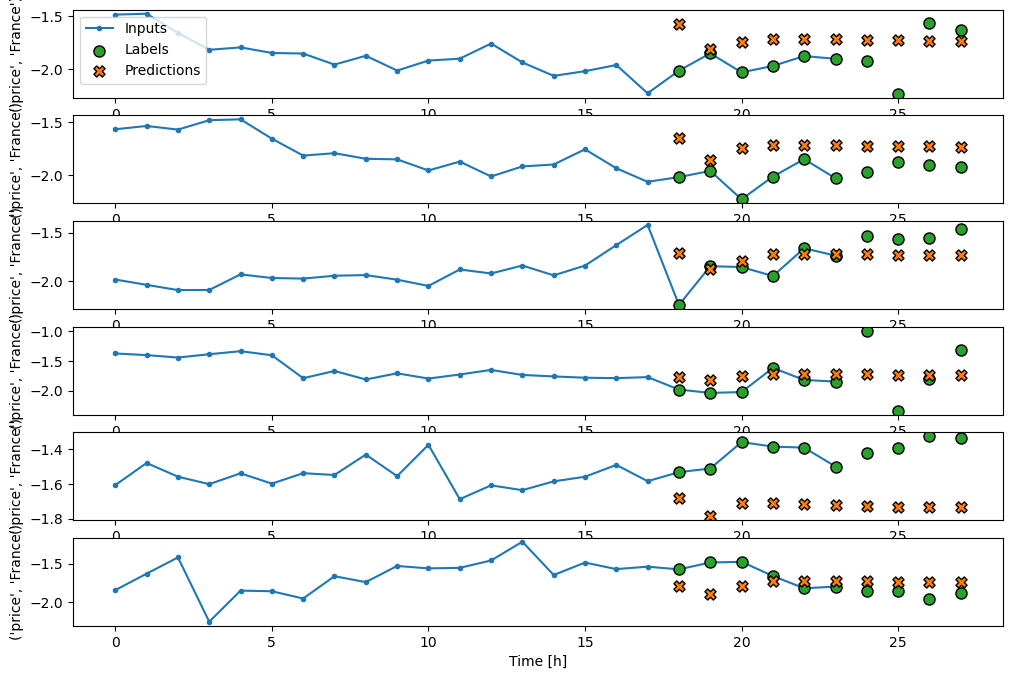

In [99]:
val_performance = {}
performance = {}

val_performance['1'] = m.evaluate(w.val)
# performance['1'] = m.evaluate(w.test)
w.plot(m, plot_col=label_columns[1], max_subplots=6)

In [ ]:
w.example

((<tf.Tensor: shape=(32, 24, 85), dtype=float32, numpy=
  array([[[-0.0846, -1.3429, -0.6165, ...,  9.3225,  7.4433,  6.5417],
          [-0.0511, -1.3371,  0.2574, ...,  9.19  ,  7.4367,  6.5033],
          [-0.0732, -1.3275,  0.2898, ...,  9.0575,  7.43  ,  6.465 ],
          ...,
          [ 0.1491, -1.6419, -0.238 , ...,  7.5933,  8.5567,  7.1867],
          [ 0.2844, -1.6431, -0.3399, ...,  7.6117,  8.7408,  7.3933],
          [ 0.5876, -1.6378, -0.5797, ...,  7.63  ,  8.925 ,  7.6   ]],
  
         [[ 0.2569, -1.3487,  0.0519, ...,  9.455 ,  7.45  ,  6.58  ],
          [-0.0846, -1.3429, -0.6165, ...,  9.3225,  7.4433,  6.5417],
          [-0.0511, -1.3371,  0.2574, ...,  9.19  ,  7.4367,  6.5033],
          ...,
          [ 0.1191, -1.6294, -0.2623, ...,  7.575 ,  8.3725,  6.98  ],
          [ 0.1491, -1.6419, -0.238 , ...,  7.5933,  8.5567,  7.1867],
          [ 0.2844, -1.6431, -0.3399, ...,  7.6117,  8.7408,  7.3933]],
  
         [[-0.2348, -1.5511,  0.2389, ...,  7.7217,  9

In [ ]:
dataset = w.train
# column_indices = w.train_df.columns.get_loc(w.label_columns)
column_indices = [w.train_df.columns.get_loc(idx) for idx in w.label_columns]
dataset.map(lambda x, y: (tf.gather(x, column_indices, axis=2), y))
# w.label_columns

<MapDataset element_spec=(TensorSpec(shape=(None, 24, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10, 5), dtype=tf.float32, name=None))>